In [1]:
# Core Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


2025-07-15 09:27:09.053951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752571629.431536      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752571629.542446      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading & Preprocessing steps.

In [2]:
dataset = "/kaggle/input/brain-tumor-dataset/Images"

In [3]:
images = []
for image_path in os.listdir(dataset):
    full_path = os.path.join(dataset, image_path)
    img = load_img(full_path, target_size=(128,128), color_mode="grayscale")
    img = img_to_array(img) / 255.0
    images.append(img)

In [4]:
images = np.array(images)

In [5]:
images.shape

(100, 128, 128, 1)

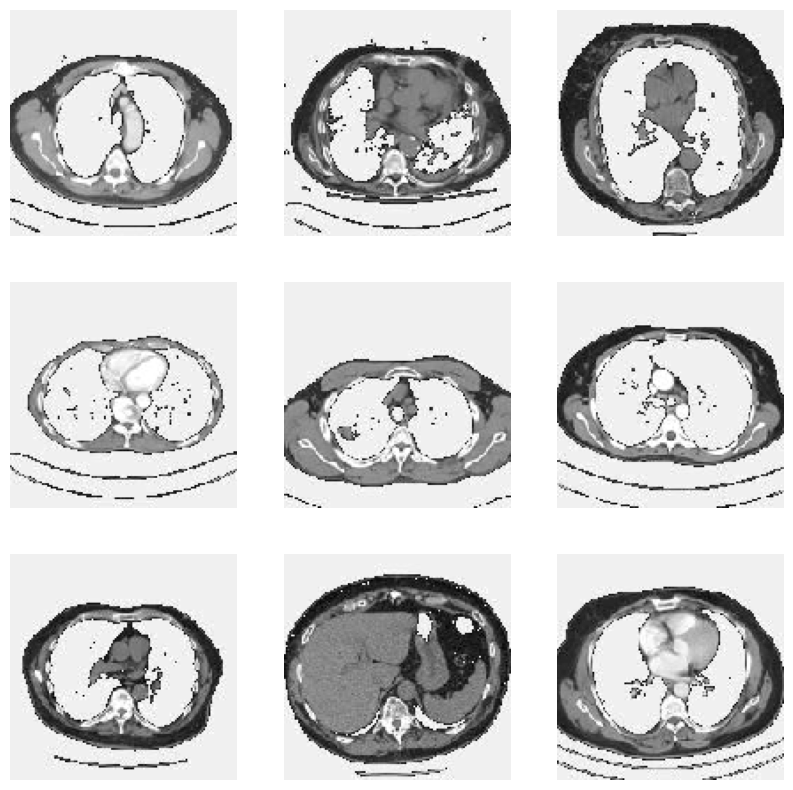

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(128, 128), cmap='gray')
    plt.axis('off')
plt.show()

In [7]:
noise_factor = 0.2

noise_images = []

for image in images:
    noisy = image + noise_factor * np.random.randn(*image.shape) # 128*128
    noisy = np.clip(noisy, 0., 1.)
    noise_images.append(noisy)

In [8]:
noise_images = np.array(noise_images)

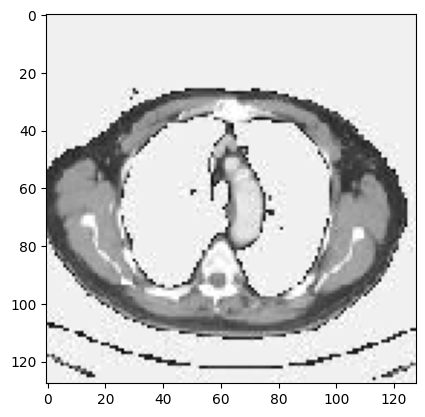

In [9]:
plt.imshow(images[0], cmap="gray")

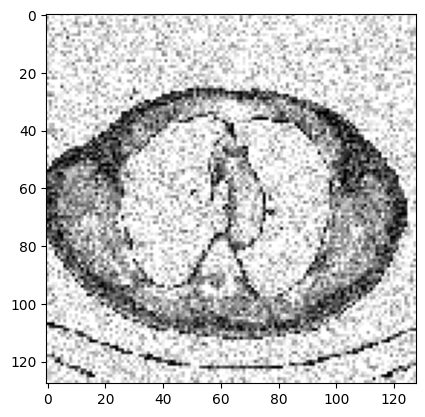

In [10]:
plt.imshow(noise_images[0], cmap="gray")

## splitting

In [11]:
normal_train = images[:80]
normal_test = images[80:]

normal_train.shape, normal_test.shape

((80, 128, 128, 1), (20, 128, 128, 1))

In [12]:
noise_train = noise_images[:80]
noise_test = noise_images[80:]

noise_train.shape, noise_test.shape

((80, 128, 128, 1), (20, 128, 128, 1))

In [13]:
# normal_train, normal_test, noise_train, noise_test = train_test_split(
#     images, noise_images, test_size=0.2, random_state=42
# )

# 1- Model Architecture

## 🔧 Basic Autoencoder Architecture

The **basic autoencoder** is a simple convolutional neural network designed to learn an identity mapping from noisy to clean images. It consists of:

- **Encoder**:
  - Stack of `Conv2D + ReLU` layers
  - `MaxPooling2D` layers to reduce spatial dimensions
- **Decoder**:
  - `Conv2D + UpSampling2D` layers
  - Reconstructs the image from encoded features

### ⚙️ Objective:
To minimize reconstruction loss by reducing noise from the input while preserving important image features.

- **Loss Function**: `Binary Crossentropy`
- **Optimizer**: `Adam`
- **Metrics**: `MAE`, `MSE`

This model acts as a baseline to compare with more advanced architectures.


In [14]:
def simple_autoencoder():
    inputs = Input(shape=(128,128,1), name='image_input')
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(inputs=inputs, outputs=decoded)
    autoencoder.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mae', 'mse'])
    
    return autoencoder

## 🚀 Optimized Autoencoder with Skip Connections (U-Net Inspired)

This model is a **deeper, more powerful autoencoder** that improves upon the basic version by:

- Using **double convolutional layers** per block (e.g., `Conv2D -> Conv2D`) for better feature extraction
- Integrating **skip connections** (like in U-Net) to retain fine-grained spatial information
- Applying a **custom loss function** that blends:
  - `Mean Absolute Error (MAE)`
  - `Structural Similarity Index (SSIM)`  
    → Ensures perceptual quality, not just pixel-level accuracy

### 🛠️ Architecture Highlights:
- **Encoder**: 3 blocks of stacked convolutions followed by pooling
- **Decoder**: Up-sampling blocks with skip connections from encoder
- **Final Layer**: `1x1 Conv2D` with `sigmoid` activation

### 🎯 Advantages:
- Better preserves edges and textures
- More resilient to complex noise patterns
- Produces sharper and more realistic outputs

This optimized architecture is ideal for tasks like medical image denoising and restoration where details matter.


In [15]:
def optimized_autoencoder():
    inputs = Input(shape=(128, 128, 1), name='image_input')
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])  # Skip connection
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])  # Skip connection
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    decoded = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    optimized_autoencoder = Model(inputs=inputs, outputs=decoded)
    
    # Compile
    def perceptual_loss(y_true, y_pred):
        mae = tf.keras.losses.mae(y_true, y_pred)
        ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
        return 0.5 * mae + 0.5 * ssim
    
    optimized_autoencoder.compile(
        optimizer='adam',
        loss = perceptual_loss,
        metrics = ['mae', 'mse']
    )
    return optimized_autoencoder

# 2- Visualization

## 1 Denoising Results Visualization

This section provides a comprehensive side-by-side visual comparison between:

- ✅ **Original Clean Images**  
- ❌ **Noisy Inputs**  
- 🔄 **Autoencoder Denoised Outputs**  
- 🧯 **Difference Maps (Heatmap of Residual Noise)**

### 📌 Description:

| Column | What it Shows |
|--------|----------------|
| 1️⃣ | Ground truth (clean image) |
| 2️⃣ | Noisy version fed into the model |
| 3️⃣ | Output predicted by the autoencoder |
| 4️⃣ | Heatmap of pixel-wise difference between original and denoised image (visual noise reduction) |

If available, **PSNR (Peak Signal-to-Noise Ratio)** is displayed on the difference map, offering a quantitative insight into denoising performance per sample.

### 🎯 Why It's Useful:
- Helps visually **validate model performance**.
- Identifies areas where the model may underperform.
- Offers a quick glance at **restoration quality** for both experts and non-technical stakeholders.


In [16]:
def visualize_denoising_results(normal_test, noise_test, predictions, psnr_scores=None, n_images=8):
    """
    Visualizes original, noisy, denoised, and difference images side by side.

    Parameters:
    - normal_test: Ground truth clean images (NumPy array)
    - noise_test: Noisy input images (NumPy array)
    - predictions: Denoised output from the model (NumPy array)
    - psnr_scores: Optional list/array of PSNR values for each sample
    - n_images: Number of random samples to display (default = 8)
    """
    fig, axes = plt.subplots(n_images, 4, figsize=(16, n_images * 3))

    for i in range(n_images):
        idx = np.random.randint(0, len(normal_test))
        
        original = normal_test[idx].squeeze()
        noisy = noise_test[idx].squeeze()
        denoised = predictions[idx].squeeze()
        difference = np.abs(original - denoised)

        # Original clean image
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # Noisy image
        axes[i, 1].imshow(noisy, cmap='gray')
        axes[i, 1].set_title('Noisy')
        axes[i, 1].axis('off')
        
        # Denoised image
        axes[i, 2].imshow(denoised, cmap='gray')
        axes[i, 2].set_title('Denoised')
        axes[i, 2].axis('off')
        
        # Difference heatmap
        axes[i, 3].imshow(difference, cmap='hot')
        title = 'Difference'
        if psnr_scores is not None:
            title += f' (PSNR: {psnr_scores[idx]:.1f})'
        axes[i, 3].set_title(title)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

## 2 Training Performance Visualization

The following plot shows how the model's performance evolved over epochs in terms of:

- **Loss** (MSE): Measures how well the autoencoder reconstructs the input.
- **MAE** (Mean Absolute Error): Gives insight into average reconstruction error.
- **MSE** (Mean Squared Error): Penalizes larger errors more than MAE.

This helps in identifying **overfitting**, **underfitting**, or convergence issues early.

In [17]:
def plot_training_history(history, title_prefix="Model"):
    """
    Plots the training and validation loss, MAE, and MSE from a Keras History object.

    Parameters:
    - history: Keras History object (from model.fit)
    - title_prefix: Optional string to prefix titles (e.g., 'Autoencoder', 'Denoiser')
    """
    metrics = ['loss', 'mae', 'mse']
    titles = ['Loss', 'MAE', 'MSE']
    
    plt.figure(figsize=(12, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label=f'Training {titles[i]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}')
        plt.title(f'{title_prefix} {titles[i]}')
        plt.xlabel('Epoch')
        plt.ylabel(titles[i])
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


## 3 📊 Histogram Analysis of Pixel Intensity

This visualization compares pixel intensity distributions for:

- 🟦 Original Image
- 🟥 Noisy Image
- 🟩 Denoised Image

It helps assess how well the autoencoder restores the original distribution after denoising.
A well-trained model should produce a histogram shape similar to the original.

In [18]:
def plot_image_histograms(normal_img, noisy_img, denoised_img, sample_idx=0):
    """
    Plots histograms of pixel intensity for original, noisy, and denoised images.
    
    Parameters:
    - normal_img: Array of original clean images (e.g., normal_test)
    - noisy_img: Array of noisy images (e.g., noise_test)
    - denoised_img: Array of predicted/denoised images (e.g., predictions)
    - sample_idx: Index of the sample image to analyze
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(normal_img[sample_idx].flatten(), bins=50, alpha=0.7, color='blue')
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(noisy_img[sample_idx].flatten(), bins=50, alpha=0.7, color='red')
    plt.title('Noisy Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(denoised_img[sample_idx].flatten(), bins=50, alpha=0.7, color='green')
    plt.title('Denoised Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## 🔍 Zoom-In & Edge Detection Comparison

This visualization provides a closer look at how effectively the autoencoder removes noise and preserves important structural features in the image.

### 🎯 Breakdown of the Columns:
| 🔢 Column | 📝 Description |
|----------|----------------|
| 1️⃣ | Full-sized image (Original / Noisy / Denoised) with a red rectangle highlighting the zoom area |
| 2️⃣ | Zoomed-in crop of the selected region to inspect local details |
| 3️⃣ | Edge map (Canny detection) to evaluate edge preservation and structure recovery |

### 🔬 Purpose:
- **Zoomed Region** helps identify fine details that might be lost or blurred during denoising.
- **Edge Detection** highlights the model's ability to retain sharp edges, which is essential in medical imaging and fine-detail tasks.

A good denoising model should:
- Restore textures and fine details (visible in the zoomed view).
- Preserve edges and boundaries (evident in edge maps).


In [19]:
def visualize_zoom_and_edges(normal_test, noise_test, predictions, sample_idx=None, zoom_size=40):
    """
    Displays a side-by-side comparison of original, noisy, and denoised images:
    - Full image view with a red rectangle
    - Zoomed-in patch from the center
    - Edge detection using Canny

    Parameters:
    - normal_test: Ground truth clean images (NumPy array)
    - noise_test: Noisy input images (NumPy array)
    - predictions: Denoised output from the model (NumPy array)
    - sample_idx: Optional index to visualize; if None, selects a random one
    - zoom_size: The width/height of the square zoomed region (default = 40)
    """
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(normal_test))
    
    h, w = normal_test.shape[1:3]
    start_h, start_w = h // 2 - zoom_size // 2, w // 2 - zoom_size // 2
    
    titles = ['Original', 'Noisy', 'Denoised']
    images = [normal_test[sample_idx], noise_test[sample_idx], predictions[sample_idx]]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        img = images[i].squeeze()
        
        # Full image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        # Add red zoom box
        rect = plt.Rectangle((start_w, start_h), zoom_size, zoom_size, 
                             linewidth=2, edgecolor='red', facecolor='none')
        axes[i, 0].add_patch(rect)

        # Zoomed region
        zoomed = img[start_h:start_h + zoom_size, start_w:start_w + zoom_size]
        axes[i, 1].imshow(zoomed, cmap='gray')
        axes[i, 1].set_title(f'{titles[i]} (Zoomed)')
        axes[i, 1].axis('off')

        # Edge detection
        edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
        axes[i, 2].imshow(edges, cmap='gray')
        axes[i, 2].set_title(f'{titles[i]} (Edges)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [20]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

## 📊 Evaluation Metrics: PSNR & SSIM

To quantitatively assess the denoising performance of the autoencoder, we use two popular metrics:

- **📈 PSNR (Peak Signal-to-Noise Ratio):**  
  Measures the similarity between the original and denoised images. Higher values indicate better reconstruction quality.

- **🔍 SSIM (Structural Similarity Index):**  
  Evaluates perceptual similarity, capturing changes in structural information, luminance, and contrast. Values range from 0 to 1, with 1 indicating perfect similarity.

After computing these metrics for each test image, we report the **average PSNR** and **average SSIM** as follows:


In [21]:
def evaluate_denoising_metrics(normal_test, predictions):
    """
    Calculates PSNR and SSIM between ground truth and predicted images.

    Parameters:
    - normal_test: Ground truth clean images (NumPy array)
    - predictions: Denoised output images from the model (NumPy array)

    Returns:
    - psnr_scores: List of PSNR values
    - ssim_scores: List of SSIM values
    - psnr_msg: Formatted string for average PSNR
    - ssim_msg: Formatted string for average SSIM
    """
    psnr_scores = []
    ssim_scores = []

    for i in range(len(normal_test)):
        psnr = calculate_psnr(normal_test[i], predictions[i])
        psnr_scores.append(psnr)

        ssim_score = ssim(
            normal_test[i].squeeze(),
            predictions[i].squeeze(),
            data_range=1.0
        )
        ssim_scores.append(ssim_score)

    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    psnr_msg = f"📈 Average PSNR: {avg_psnr:.2f} dB"
    ssim_msg = f"🔍 Average SSIM: {avg_ssim:.4f}"

    return psnr_scores, ssim_scores, psnr_msg, ssim_msg


# Models

## 1- Simple model

- ### model summary

In [22]:
simple_autoencoder= simple_autoencoder()
simple_autoencoder.summary()

I0000 00:00:1752571651.036812      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752571651.037572      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

- ### model training

In [23]:
simpel_history = simple_autoencoder.fit(noise_train,
                 normal_train,
                 validation_data=(noise_test, normal_test),
                 epochs=50,
                 batch_size=16)

Epoch 1/50


I0000 00:00:1752571657.271285      64 service.cc:148] XLA service 0x7c391c0025f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752571657.273025      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752571657.273055      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752571657.818812      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6369 - mae: 0.3026 - mse: 0.1153

I0000 00:00:1752571662.693811      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - loss: 0.6320 - mae: 0.2984 - mse: 0.1130 - val_loss: 0.5711 - val_mae: 0.2719 - val_mse: 0.0893
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5671 - mae: 0.2560 - mse: 0.0834 - val_loss: 0.5405 - val_mae: 0.2288 - val_mse: 0.0783
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5299 - mae: 0.2169 - mse: 0.0691 - val_loss: 0.5101 - val_mae: 0.1679 - val_mse: 0.0681
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5013 - mae: 0.1710 - mse: 0.0585 - val_loss: 0.4666 - val_mae: 0.1652 - val_mse: 0.0488
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4612 - mae: 0.1477 - mse: 0.0437 - val_loss: 0.4594 - val_mae: 0.1554 - val_mse: 0.0462
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4531 - mae: 0.1364 - mse: 0.0405 - val_loss: 0.4493 - val_mae: 0.1383 - val_mse: 0.0423
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4519 - mae: 0.1306 - mse: 0.0393 - val_loss: 0.4484 - val_mae: 0.131

# Evaluation

In [24]:
simple_predicted = simple_autoencoder.predict(noise_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# Visualization

In [25]:
psnr_scores1, ssim_scores1, psnr_msg1, ssim_msg1 = evaluate_denoising_metrics(normal_test, simple_predicted)
print(psnr_msg1)
print(ssim_msg1)

📈 Average PSNR: 16.99 dB
🔍 Average SSIM: 0.5949


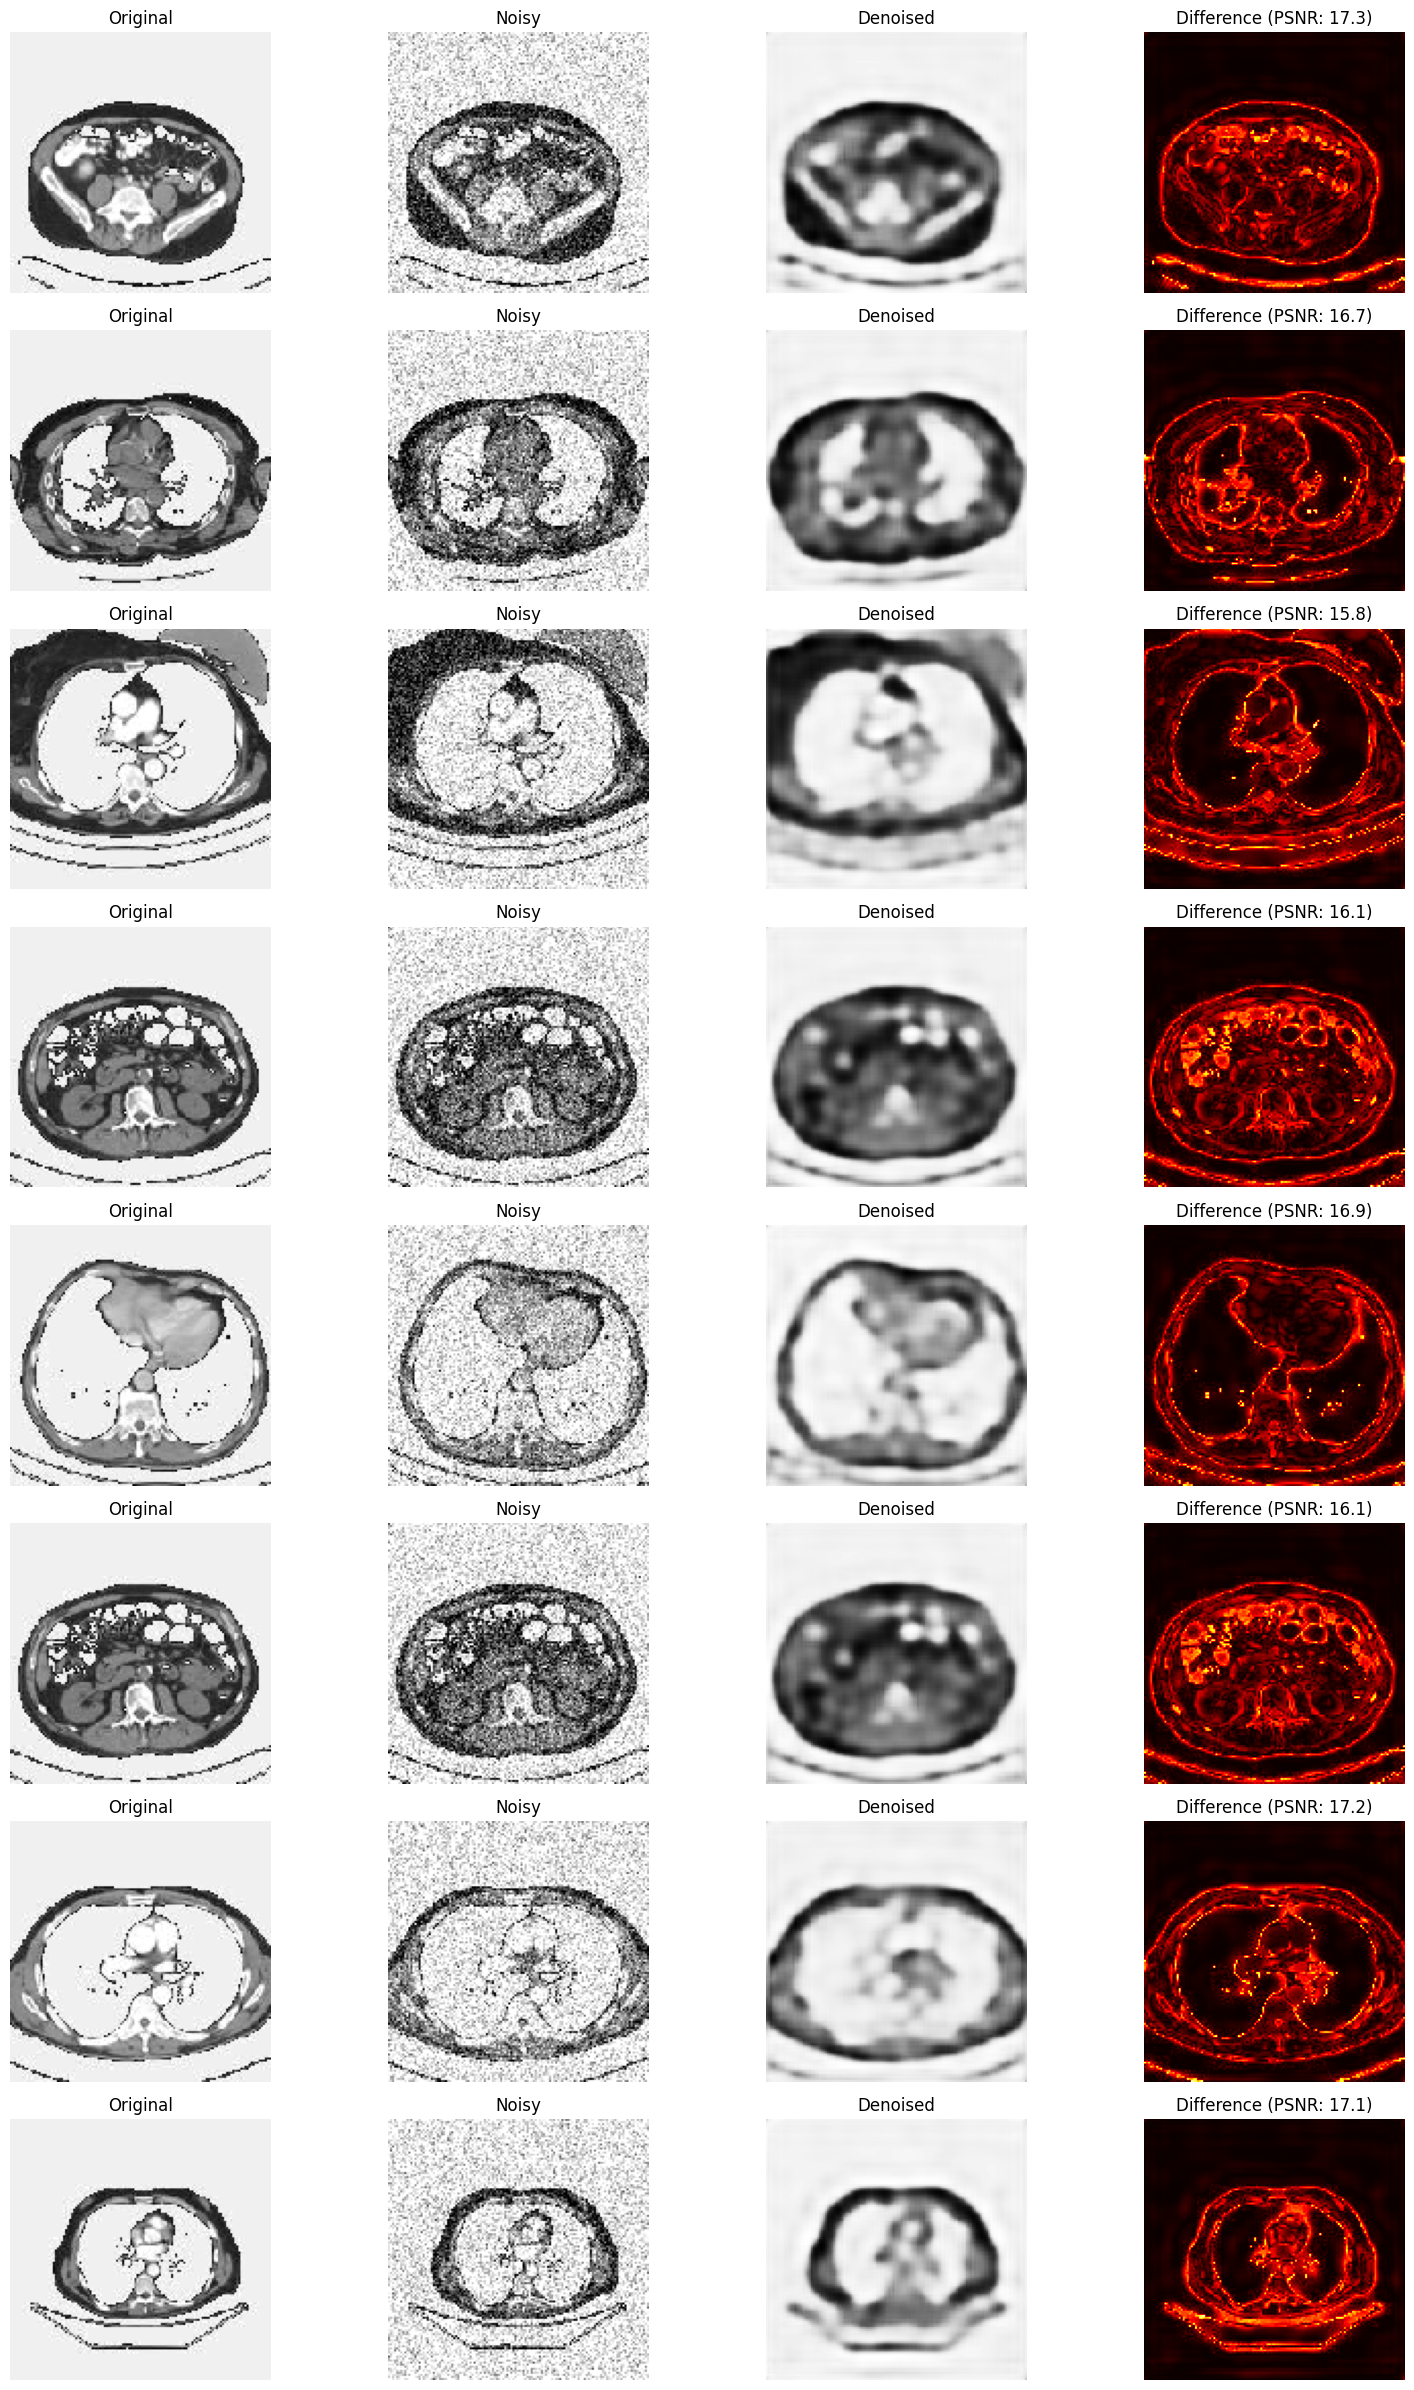

In [26]:
visualize_denoising_results(normal_test, noise_test, simple_predicted, psnr_scores1)

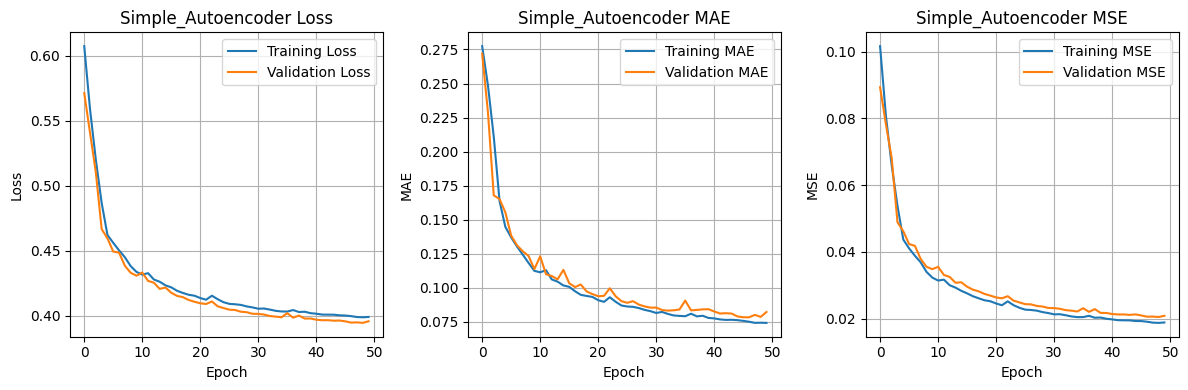

In [27]:
plot_training_history(simpel_history, title_prefix="Simple_Autoencoder")

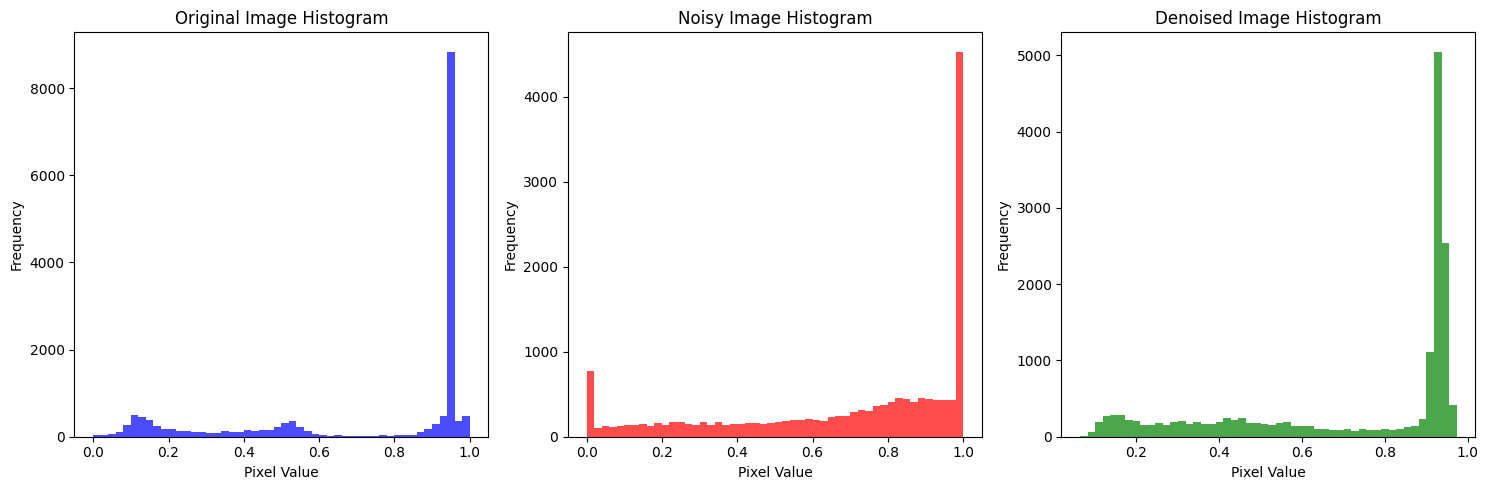

In [28]:
plot_image_histograms(normal_test, noise_test, simple_predicted, sample_idx=0)

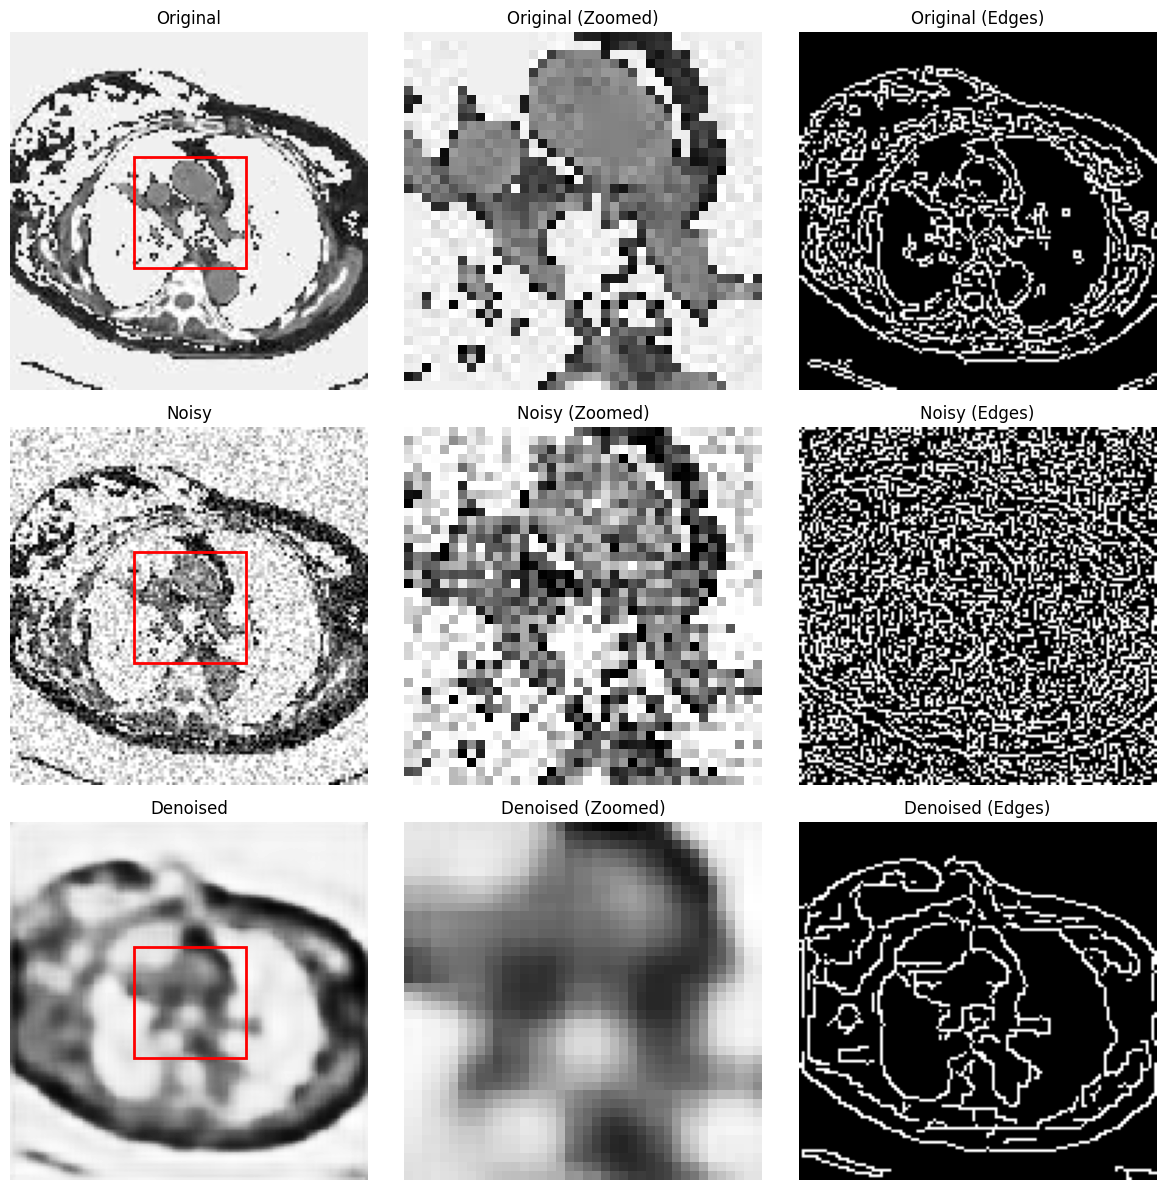

In [29]:
visualize_zoom_and_edges(normal_test, noise_test, simple_predicted, sample_idx=None, zoom_size=40)

## Optimized model

In [30]:
optimized_autoencoder = optimized_autoencoder()

In [31]:
optimized_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │        640 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_11[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 384)              │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 192)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_15[0][0] 

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

### 📉 Callbacks: EarlyStopping and ReduceLROnPlateau

To improve training performance and avoid overfitting, we use two key callbacks:

#### 🛑 EarlyStopping
- **Purpose**: Stops training when the validation loss no longer improves.
- **Parameters**:
  - `monitor='val_loss'`: Watches the validation loss.
  - `patience=10`: Waits 10 epochs without improvement before stopping.
  - `restore_best_weights=True`: Recovers the model weights from the epoch with the best validation loss.

#### 📉 ReduceLROnPlateau
- **Purpose**: Reduces the learning rate when validation loss plateaus.
- **Parameters**:
  - `monitor='val_loss'`: Monitors validation loss.
  - `factor=0.5`: Reduces learning rate by half when triggered.
  - `patience=5`: Waits 5 epochs before reducing the learning rate.
  - `min_lr=1e-6`: Ensures the learning rate doesn't fall below this minimum.

These callbacks help the model converge more efficiently and prevent overfitting.


In [32]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Train the optimized model

In [33]:
optimized_history = optimized_autoencoder.fit(
    noise_train,
    normal_train,
    validation_data=(noise_test, normal_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


W0000 00:00:1752571689.545263      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert/Assert
W0000 00:00:1752571689.546443      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_1/Assert
W0000 00:00:1752571689.547315      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_2/Assert
W0000 00:00:1752571689.547906      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_3/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.4864 - mae: 0.3135 - mse: 0.1287

W0000 00:00:1752571706.102867      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert/Assert
W0000 00:00:1752571706.103996      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_1/Assert
W0000 00:00:1752571706.104766      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_2/Assert
W0000 00:00:1752571706.105274      65 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_3/Assert
W0000 00:00:1752571710.690215      64 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert/Assert
W0000 00:00:1752571710.690522      64 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_1/Assert
W0000 00:00:1752571710.691006      64 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_2/Assert
W0000 00:00:1752571710.691286      64 assert_op.cc:38] Ignoring Assert operator compile_loss/p

5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.4830 - mae: 0.3087 - mse: 0.1286 - val_loss: 0.4580 - val_mae: 0.2600 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.4495 - mae: 0.2579 - mse: 0.1520 - val_loss: 0.4581 - val_mae: 0.2601 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.4538 - mae: 0.2655 - mse: 0.1571 - val_loss: 0.4581 - val_mae: 0.2601 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.4523 - mae: 0.2646 - mse: 0.1572 - val_loss: 0.4581 - val_mae: 0.2601 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.4481 - mae: 0.2540 - mse: 0.1482 - val_loss: 0.4581 - val_mae: 0.2601 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.4403 - mae: 0.2517 - mse: 0.1464 - val_loss: 0.4581 - val_mae: 0.2601 - val_mse: 0.1575 - lea

In [34]:
optimized_predicted = optimized_autoencoder.predict(noise_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [35]:
psnr_scores2, ssim_scores2, psnr_msg2, ssim_msg2 = evaluate_denoising_metrics(normal_test, optimized_predicted)
print(psnr_msg2)
print(ssim_msg2)

📈 Average PSNR: 8.34 dB
🔍 Average SSIM: 0.3684


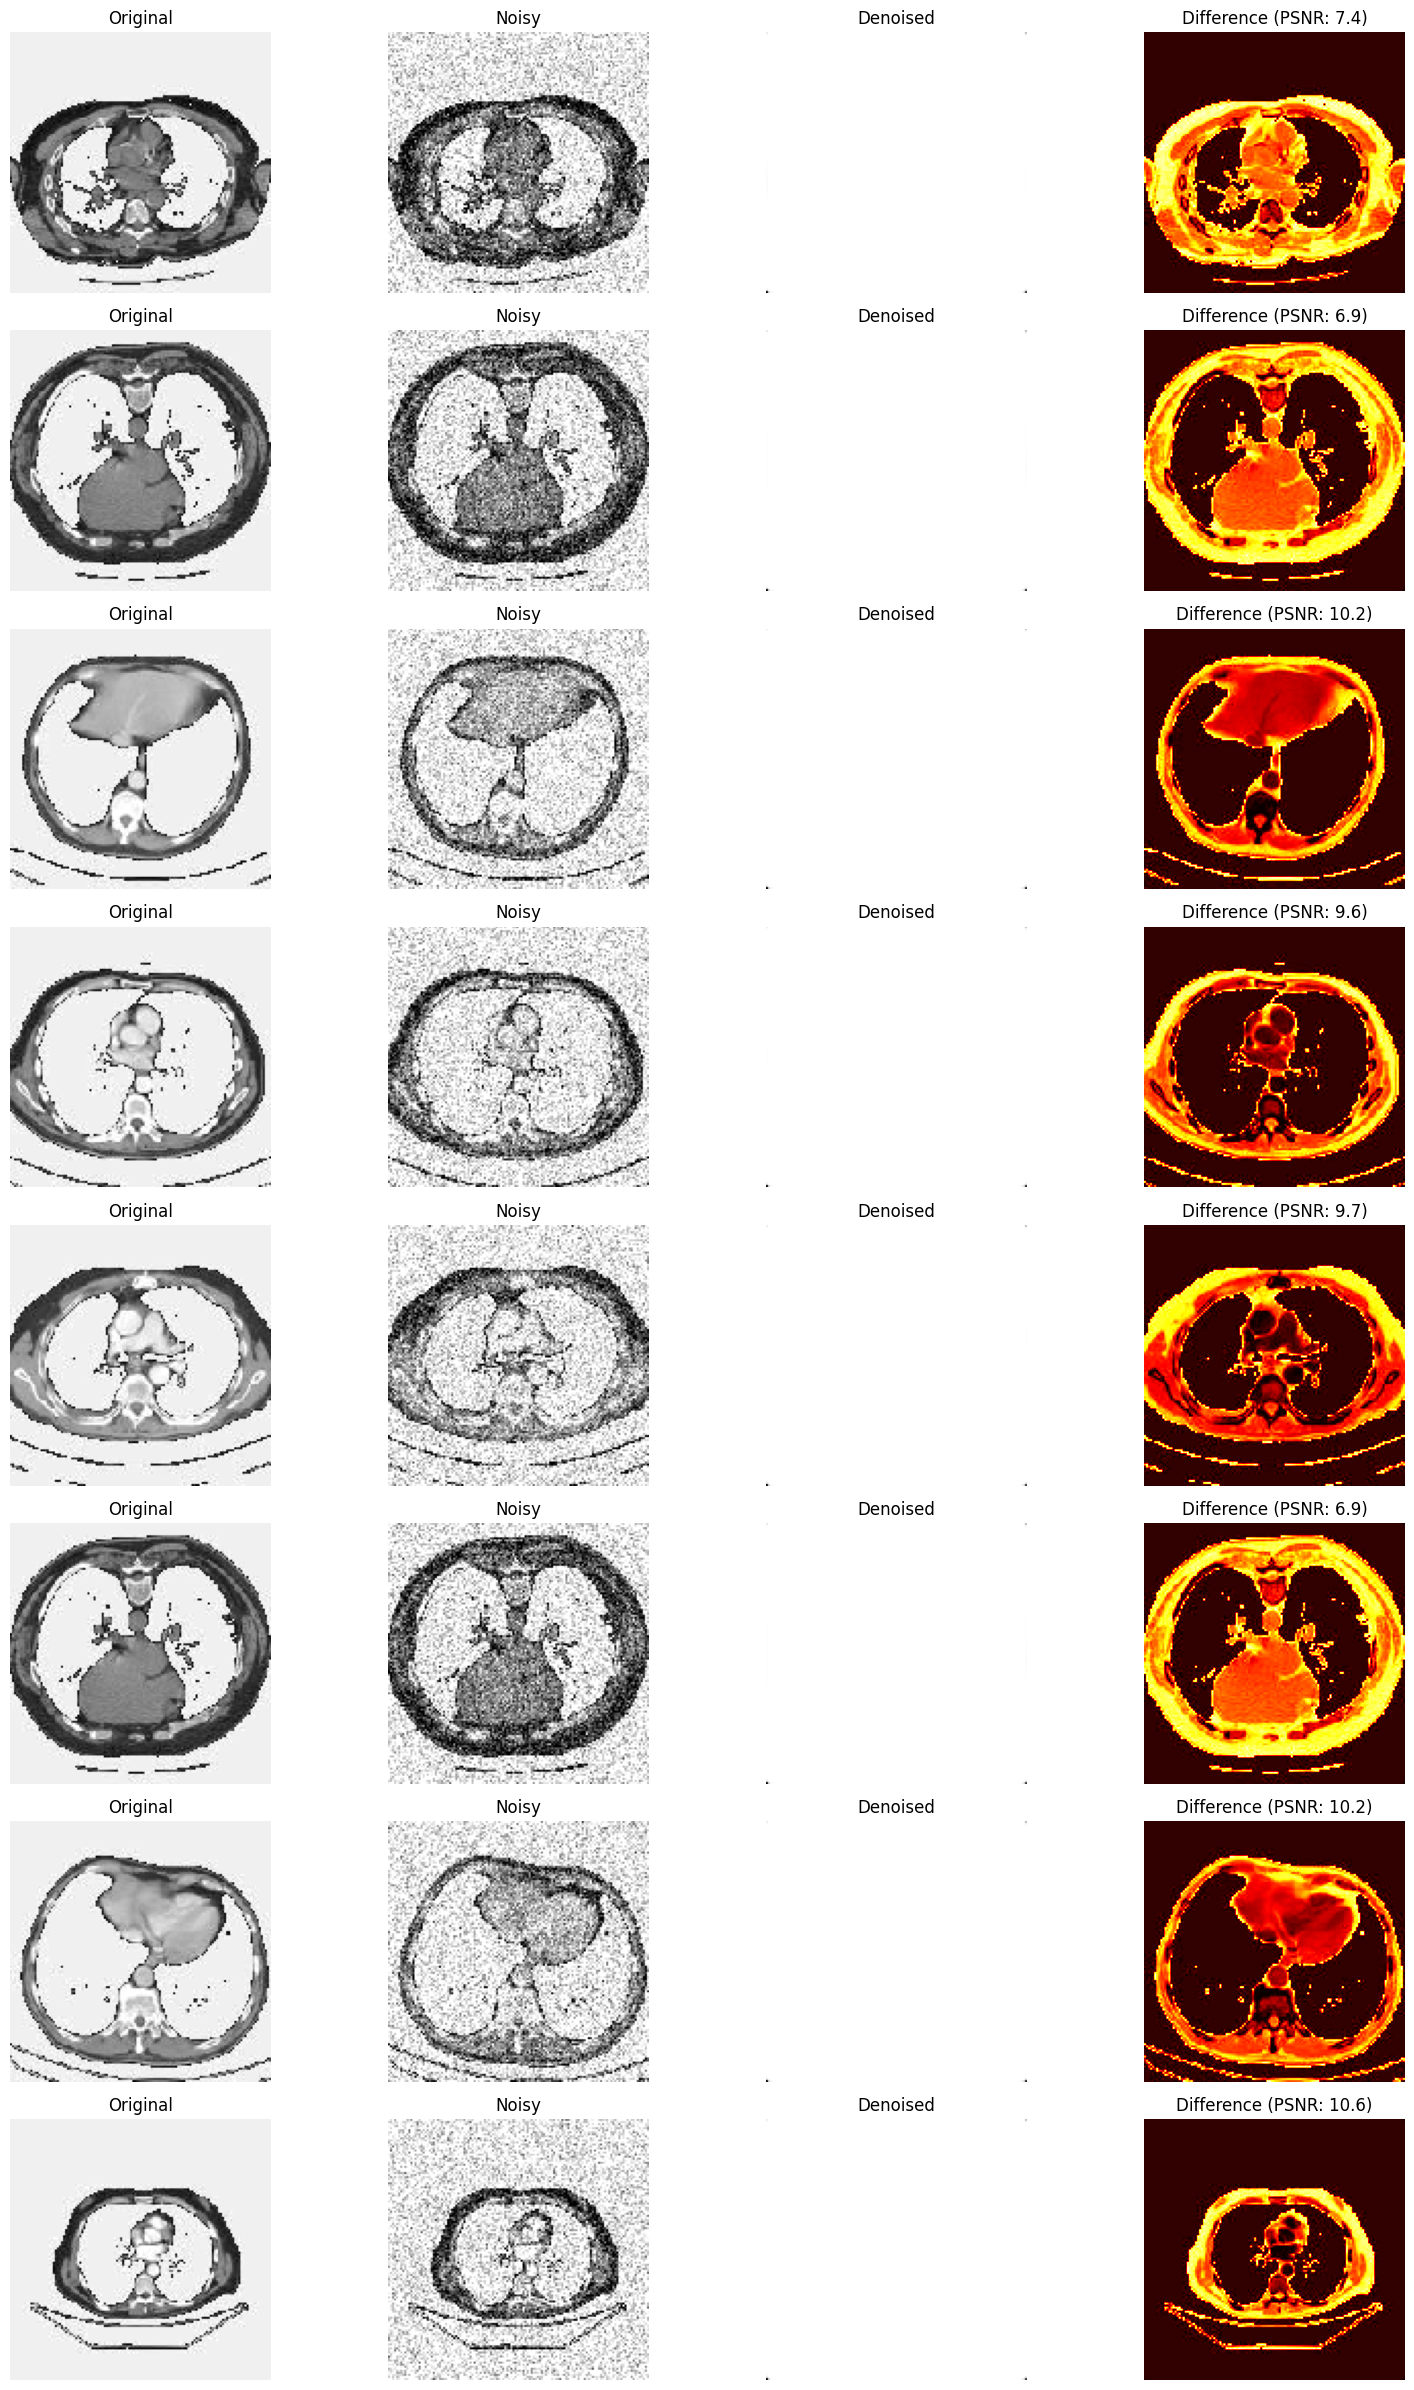

In [36]:
visualize_denoising_results(normal_test, noise_test, optimized_predicted, psnr_scores2)

# Plot training history

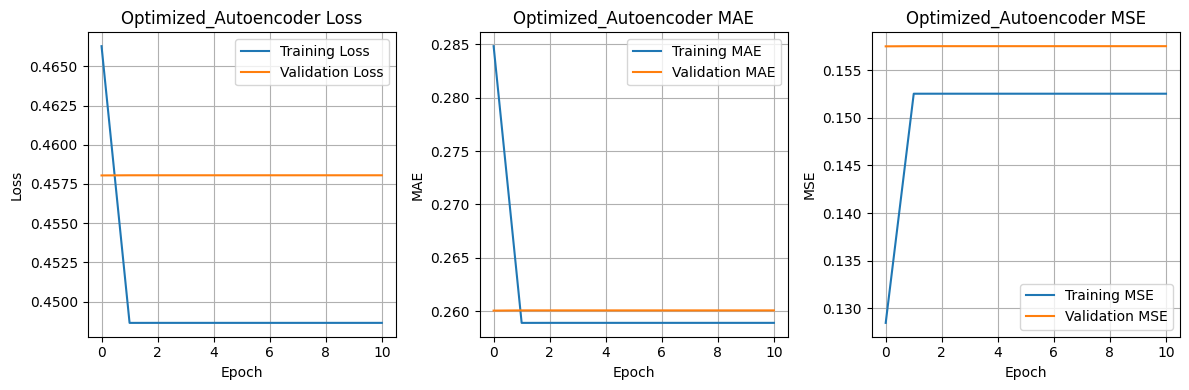

In [37]:
plot_training_history(optimized_history, title_prefix="Optimized_Autoencoder")

# Compare histograms

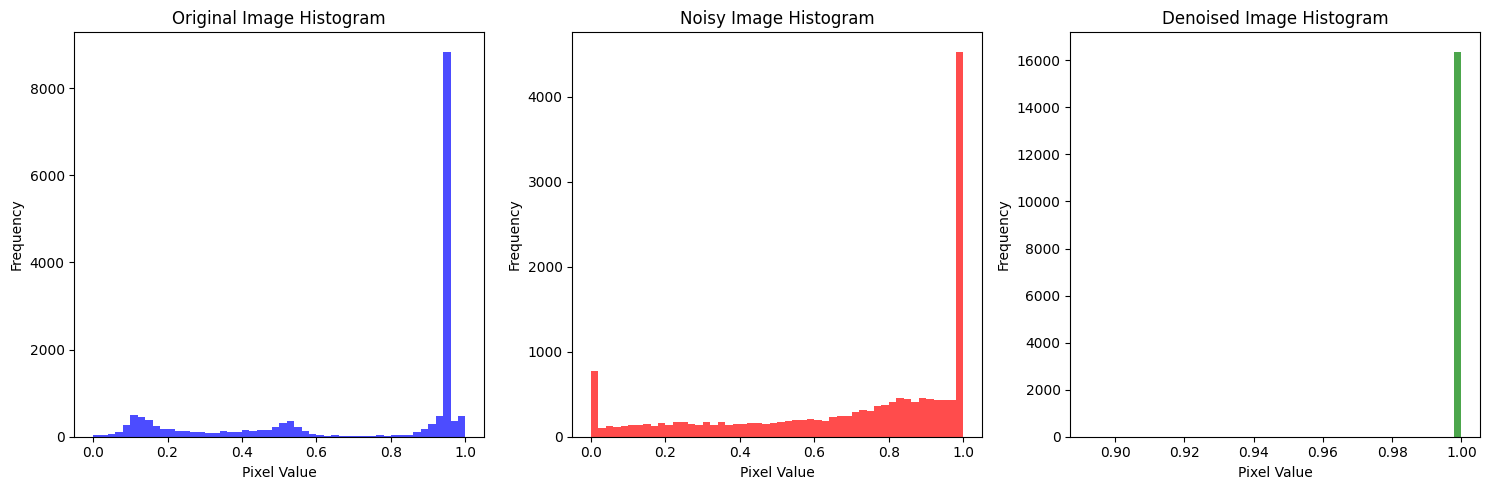

In [38]:
plot_image_histograms(normal_test, noise_test, optimized_predicted, sample_idx=0)

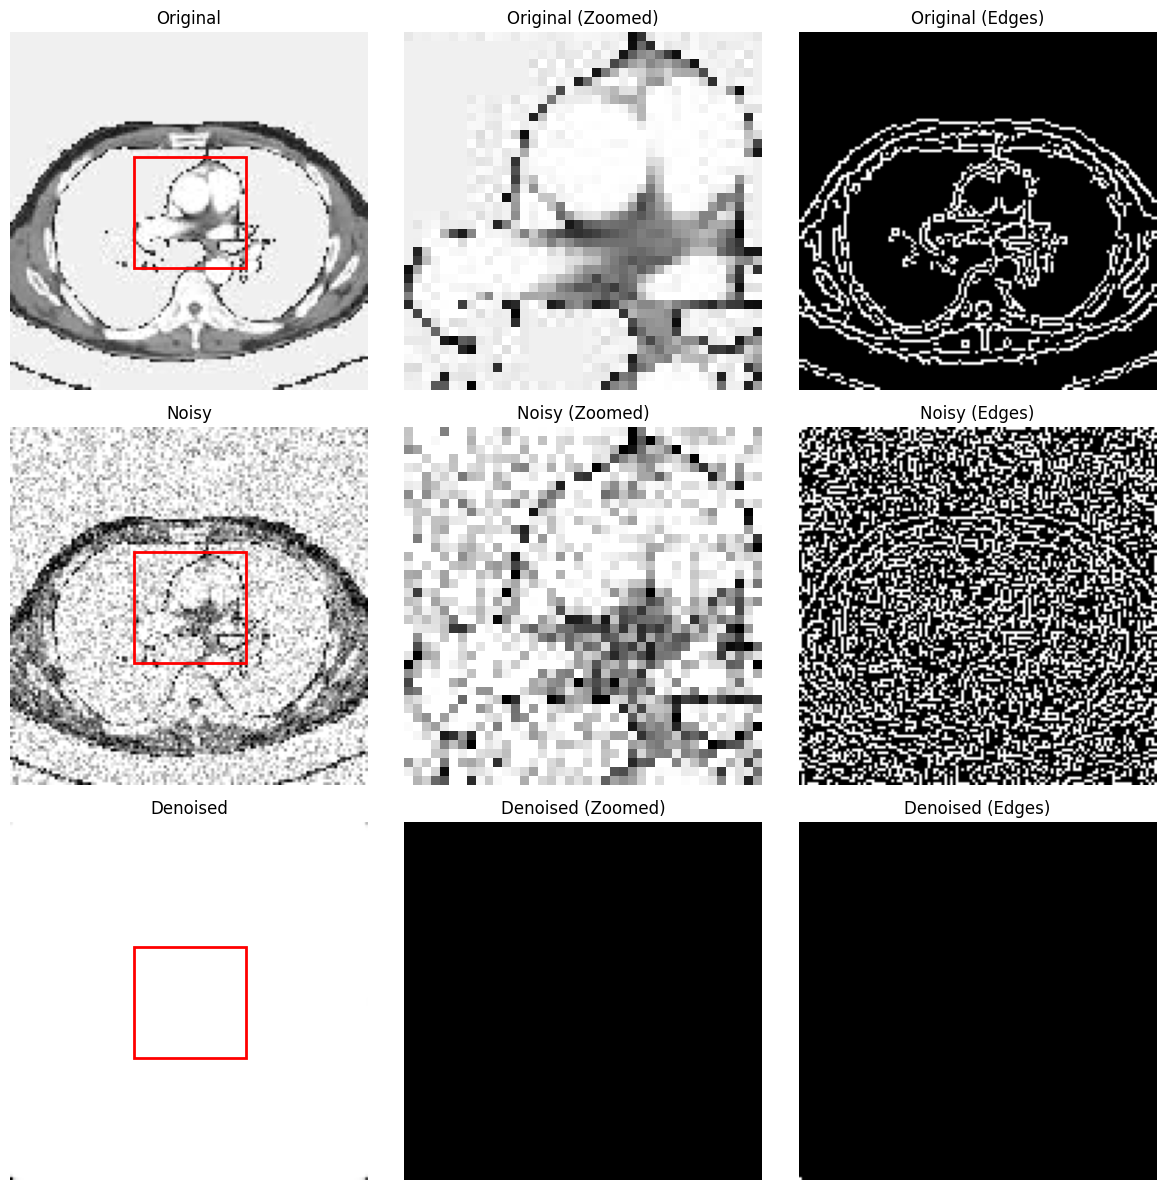

In [39]:
visualize_zoom_and_edges(normal_test, noise_test, optimized_predicted, sample_idx=None, zoom_size=40)

## Evaluation for 2 models

In [40]:
eval1 = simple_autoencoder.evaluate(noise_test, normal_test, verbose=0)
eval2 = optimized_autoencoder.evaluate(noise_test, normal_test, verbose=0)

W0000 00:00:1752571735.135902      67 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert/Assert
W0000 00:00:1752571735.136115      67 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_1/Assert
W0000 00:00:1752571735.136586      67 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_2/Assert
W0000 00:00:1752571735.136860      67 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/SSIM/Assert_3/Assert


In [41]:
print("\n=== 📊 Performance Summary: Model Comparison ===")

print("🔧 Autoencoder Model 1:")
print(f"Test Loss     : {eval1[0]:.4f}")
print(f"Test MAE      : {eval1[1]:.4f}")
print(f"Test MSE      : {eval1[2]:.4f}")
print(f"Average PSNR  : {np.mean(psnr_scores1):.3f} dB (Higher is better)")
print(f"Average SSIM  : {np.mean(psnr_scores1):.4f} (Closer to 1 is better)")
print(f"Min PSNR      : {np.min(psnr_scores1):.2f} dB")
print(f"Max PSNR      : {np.max(psnr_scores1):.2f} dB")

print("\n⚙️ Autoencoder Model 2:")
print(f"Test Loss     : {eval2[0]:.4f}")
print(f"Test MAE      : {eval2[1]:.4f}")
print(f"Test MSE      : {eval2[2]:.4f}")
print(f"Average PSNR  : {np.mean(psnr_scores2):.3f} dB (Higher is better)")
print(f"Average SSIM  : {np.mean(psnr_scores2):.4f} (Closer to 1 is better)")
print(f"Min PSNR      : {np.min(psnr_scores2):.2f} dB")
print(f"Max PSNR      : {np.max(psnr_scores2):.2f} dB")



=== 📊 Performance Summary: Model Comparison ===
🔧 Autoencoder Model 1:
Test Loss     : 0.3956
Test MAE      : 0.0823
Test MSE      : 0.0208
Average PSNR  : 16.988 dB (Higher is better)
Average SSIM  : 16.9877 (Closer to 1 is better)
Min PSNR      : 13.63 dB
Max PSNR      : 19.90 dB

⚙️ Autoencoder Model 2:
Test Loss     : 0.4580
Test MAE      : 0.2600
Test MSE      : 0.1575
Average PSNR  : 8.342 dB (Higher is better)
Average SSIM  : 8.3423 (Closer to 1 is better)
Min PSNR      : 5.40 dB
Max PSNR      : 11.83 dB
